# Transformer Chatbot

In [ ]:
def restart_runtime():
  os.kill(os.getpid(), 9)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

!pip install tensorflow==2.3.1
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

!pip install tensorflow-datasets==4.1.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt
import random

print("Tensorflow version {}".format(tf.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tensorflow version 2.3.1


### GPU / TPU initialization

On Google Colab, select `TPU` or `GPU` hardware accelerator.


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.61.39.226:8470']


REPLICAS: 8


## Hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [ ]:
ATTEMPT = 1
# Maximum sentence length
MAX_LENGTH = 20

# Maximum number of samples to preprocess
MAX_SAMPLES = 70000 # 0 = for All of data otherwise mention the size

# Cut off value of words in the dictionary
TRESHOLD_VALUE = 1

# For tf.data.Dataset
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000 #Shuffle data in the dataset

# For Transformer
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 16
UNITS = 512
DROPOUT = 0.3

EPOCHS = 40
TRAINING_RATIO = 0.9

## Prepare Dataset

### load data

In [ ]:
import pandas as pd
# Old dataset
# data_set_url = 'https://raw.githubusercontent.com/DevindiSiwurathna/Cornell_Chatbot-V_1.0/main/sinhala.csv'
#data_set_url = 'https://raw.githubusercontent.com/dalin-aranga/Sinhala-Dataset/main/Final.csv'
data_set_url = 'https://raw.githubusercontent.com/dalin-aranga/Sinhala-Dataset/main/Final.csv'
b_data=pd.read_csv( data_set_url , header = None)
b_data=b_data.astype(str)
# b_data.drop(b_data.columns[[1]], axis = 1, inplace = True)
if MAX_SAMPLES == 0 or len(b_data[:][1:]) < MAX_SAMPLES:
  b_data = b_data[:][1:]
else:
  b_data = b_data[:][1:MAX_SAMPLES]
print("Number of data :" + str(len(b_data)))

Number of data :31644


### Seperate Questions and Answers

In [ ]:
questions = b_data[0].tolist()
answers = b_data[1].tolist()

In [ ]:
for i in random.sample(range(1, 1000), 4):
  print("Question :"+questions[i] + "Answer :"+answers[i])

Question :අපි කවදාවත් අපේ ප්‍රශ්න ගැන කතා කරන් නැද්ද ?Answer :නෑ
Question :ඔයාට නින්ද ගියාදAnswer :ඔව්
Question :මානව හිමිකම් ගැන මොකද හිතන්නේ?Answer :මොකුත් හිතන්නෙ නෑ
Question :සුවදක් දැනෙනවා නේද?Answer :ඔව් 


In [ ]:
len(answers)

31644

## Sinhala Preprocessor

In [ ]:
# -*- coding: utf-8 -*-
import re


class SinhalaPreprocessor:

    @classmethod
    def preprocess_sentence(cls, sentence):
        # There are some &quote while the words
        sentence = re.sub(r"&quot", " ", sentence)
        # - and long hypen should replace with space
        sentence = re.sub(r"([\-–])", " ", sentence)
        # stripe "  සිංහල    භාෂාව " => " සිංහල භාෂාව "
        sentence = sentence.strip()
        # 40,000 -> 40000
        sentence = re.sub(r",000", r"000", sentence)
        # <u>නැගෙනහිර යුරෝපය</u> => නැගෙනහිර යුරෝපය U can be simple or capital
        # Here anything could be between the tag
        sentence = re.sub(r"(<.*?>)+(.*?)(<.*?>)*", r" \2 ", sentence)
        # Here I consider ? . ! , as single words
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        # 100ක් -> 100 ක්
        sentence = re.sub(r"([\d]+)", r" \1 ", sentence)
        # remove `~@#$%^&*()_+=/><':;}{[]|\ “‘
        sentence = re.sub(r"([“‘`~@#$%^&*()_+=/><':;}{\[\]\\|])", "", sentence)
        # remove double quotes
        sentence = re.sub(r'[" "]+', " ", sentence)
        return sentence

    @classmethod
    def preprocess_sentences(cls, sentences):
        new_sentences = []
        for sentence in sentences:
            new_sentences.append(cls.preprocess_sentence(sentence))
        return new_sentences

# u([\u0D80-\u0DFF]+)u - to recognize sinhala words


In [ ]:
sinhala_pre = SinhalaPreprocessor()
questions = sinhala_pre.preprocess_sentences(questions)
answers = sinhala_pre.preprocess_sentences(answers)
# questions = sinhala_pre.preprocess_sentences(questions)

## Seperate Train and test data

In [ ]:
import math

training_len = math.floor(len(questions)*TRAINING_RATIO)

train_questions = questions[:training_len]
train_answers = answers[:training_len]

test_questions = questions[training_len:]
test_answers = answers[training_len:]

In [ ]:
len(train_questions) + len(test_questions)

31644

### Number of Questions

In [ ]:
len(questions)

31644

### Sample question and Answer

In [ ]:
print('Sample question: {}'.format(train_questions[20]))
print('Sample answer: {}'.format(train_answers[20]))

Sample question: කීයටද යන්නේ
Sample answer:  8 30 ට මම මෙහෙ යනවා


## Sinhala Tokenizer

In [ ]:
import json
import pickle


class SinhalaTokenizer:
    def __init__(self):
        self.sentence2int = {}
        self.int2word = {}
        self.vocab_size = 0

    def build_dictionaries(self, s , threshold_val):
        # count each unique words
        word2count = {}
        for sentence in s:
            for word in sentence.split():
                if word not in word2count:
                    word2count[word] = 1
                else:
                    word2count[word] += 1

        # take equal or above count according to the threshold value
        threshold_value = threshold_val
        self.sentence2int = {}
        word_number = 0

        # adding tokens
        tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
        for token in tokens:
            self.sentence2int[token] = len(self.sentence2int) + 1
            word_number += 1

        # tokenizing word
        for word, count in word2count.items():
            if count >= threshold_value:
                self.sentence2int[word] = word_number
                word_number += 1

        self.vocab_size = word_number

        # Creating the inverse dictionary of the sentence2int dictionary
        self.int2word = {w_i: w for w, w_i in self.sentence2int.items()}

    def encode(self, sentence):
        # return tokenized sentences
        ints = []
        for word in sentence.split():
            if word not in self.sentence2int:
                ints.append(self.sentence2int['<OUT>'])
            else:
                ints.append(self.sentence2int[word])
        return ints

    def decode(self, ints):
        sentence = ''
        for i in ints:
            if i not in self.int2word:
                sentence = sentence + ' ' + self.int2word['<OUT>']
            else:
                sentence = sentence + ' ' + self.int2word[i]
        return sentence

    def save_data_to_pickle_file(self, name):
        f = open(name, "wb")
        pickle.dump([self.int2word, self.sentence2int], f)
        # close file
        f.close()

    def create_data_using_pickle_file(self, path):
        a_file = open(path, "rb")
        self.int2word, self.sentence2int = pickle.load(a_file)
        self.vocab_size = len(self.int2word)

    def save_sinhala_words_to_txt(self):
        with open('Sinhala_dictionary.txt', 'w', encoding='utf-8') as convert_file:
            convert_file.write(json.dumps(self.sentence2int, ensure_ascii=False, indent=4, sort_keys=True))


## Process data to train

In [ ]:
tokenizer = SinhalaTokenizer()
tokenizer.build_dictionaries(train_questions + test_answers+train_answers+test_questions, 1) 


tokenizer.save_data_to_pickle_file("data.pkl");
tokenizer.save_sinhala_words_to_txt()
# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
tokenizer.vocab_size

17665

In [ ]:
x = tokenizer.int2word

In [ ]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  for (sentence1, sentence2) in zip(inputs, outputs):

    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
    # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding = 'post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding= 'post')
    
  return tokenized_inputs, tokenized_outputs


train_questions, train_answers = tokenize_and_filter(train_questions, train_answers)
test_questions, test_answers = tokenize_and_filter(test_questions, test_answers)

In [ ]:
questions[20]

'කීයටද යන්නේ'

In [ ]:
train_questions[20]

array([17665,     4,     5, 17666,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 5]


In [ ]:
# questions1.append()
train_questions
# np.append(questions1, [0,9,7,] , axis=0)

array([[17665,     4,     5, ...,     0,     0,     0],
       [17665,     6,     7, ...,     0,     0,     0],
       [17665,     9,    10, ...,     0,     0,     0],
       ...,
       [17665,  6072,     5, ...,     0,     0,     0],
       [17665,  4232,  2927, ...,     0,     0,     0],
       [17665,    56,  4232, ...,     0,     0,     0]], dtype=int32)

In [ ]:
len(questions)

31644

In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(train_questions)))

Vocab size: 17667
Number of samples: 28462


## Tokenized words

### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [ ]:
def make_dataset(data_questions, data_answers):
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': data_questions,
          'dec_inputs': data_answers[:, :-1]
      },
      {
          'outputs': data_answers[:, 1:]
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = make_dataset(train_questions,train_answers)
test_dataset = make_dataset(test_questions,test_answers)

In [ ]:
print(train_dataset)

<PrefetchDataset shapes: ({inputs: (None, 20), dec_inputs: (None, 19)}, {outputs: (None, 19)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## Attention



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)
  
  def get_config(self):
        config = super(MultiHeadAttention,self).get_config()
        config.update({
            'num_heads':self.num_heads,
            'd_model':self.d_model,
        })
        return config

  def split_heads(self, inputs, batch_size):
    inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
    return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]))(inputs)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
        scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

    # concatenation of heads
    concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)))(scaled_attention)

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs    

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  def get_config(self):

        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
            
        })
        return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

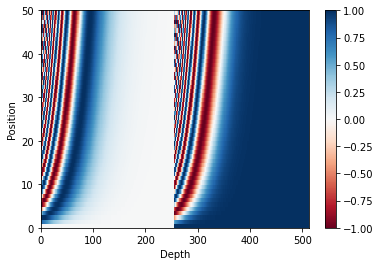

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs,attention])
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention,outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

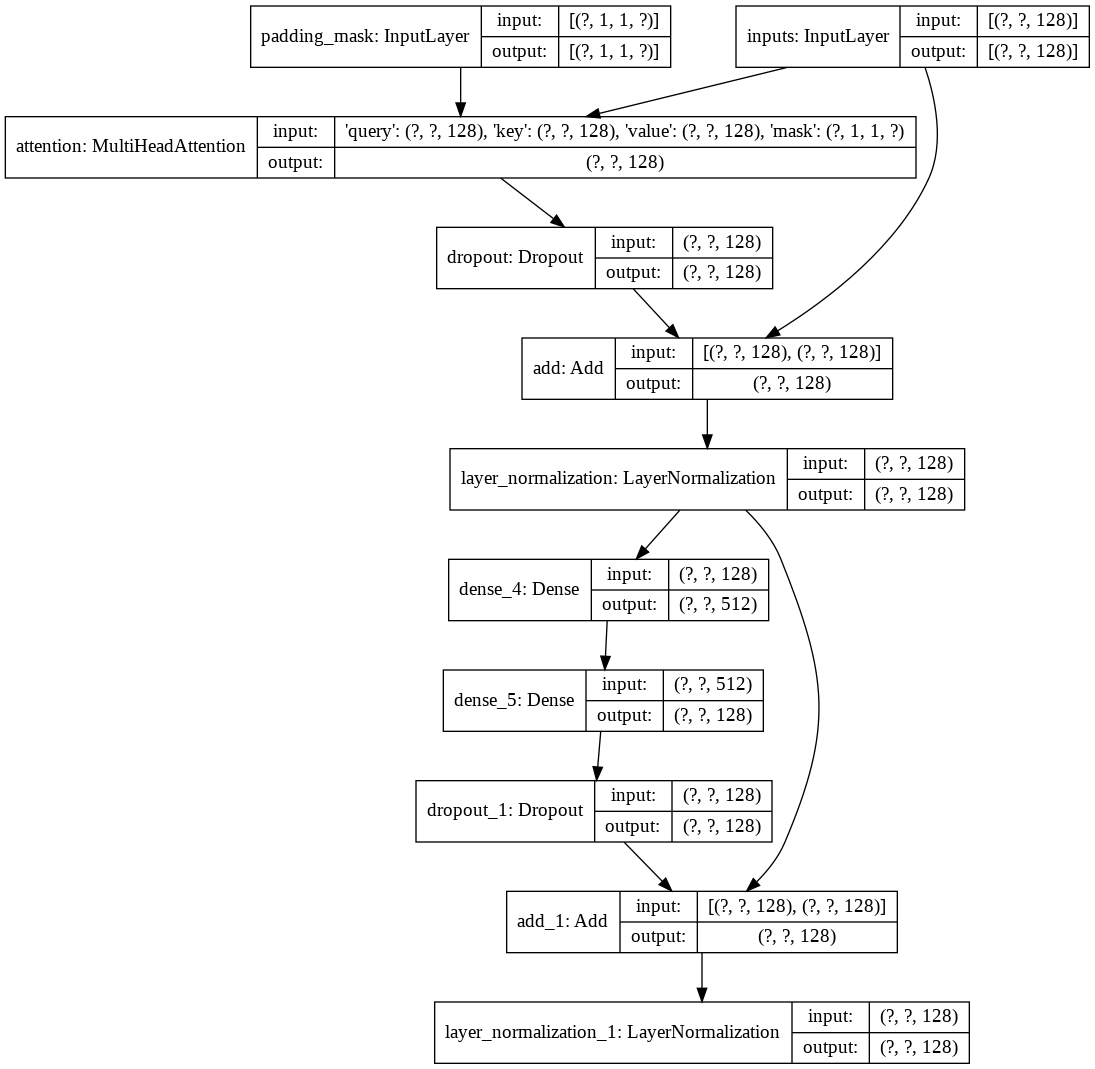

In [ ]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

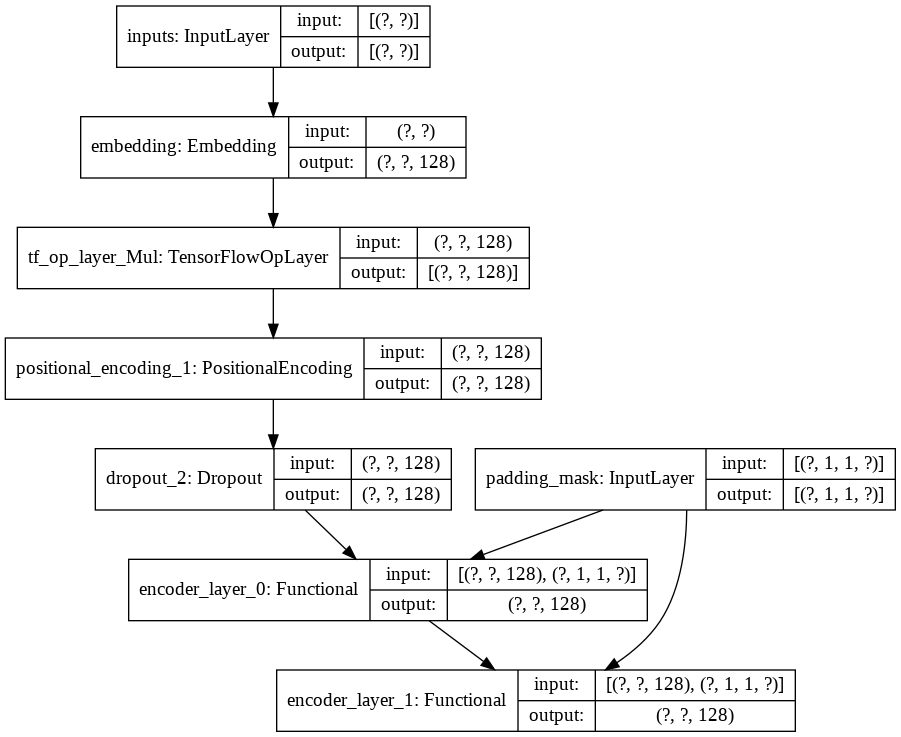

In [ ]:
sample_encoder = encoder(
    vocab_size=6000,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  add_attention = tf.keras.layers.add([attention1,inputs])    
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2,attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs,attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

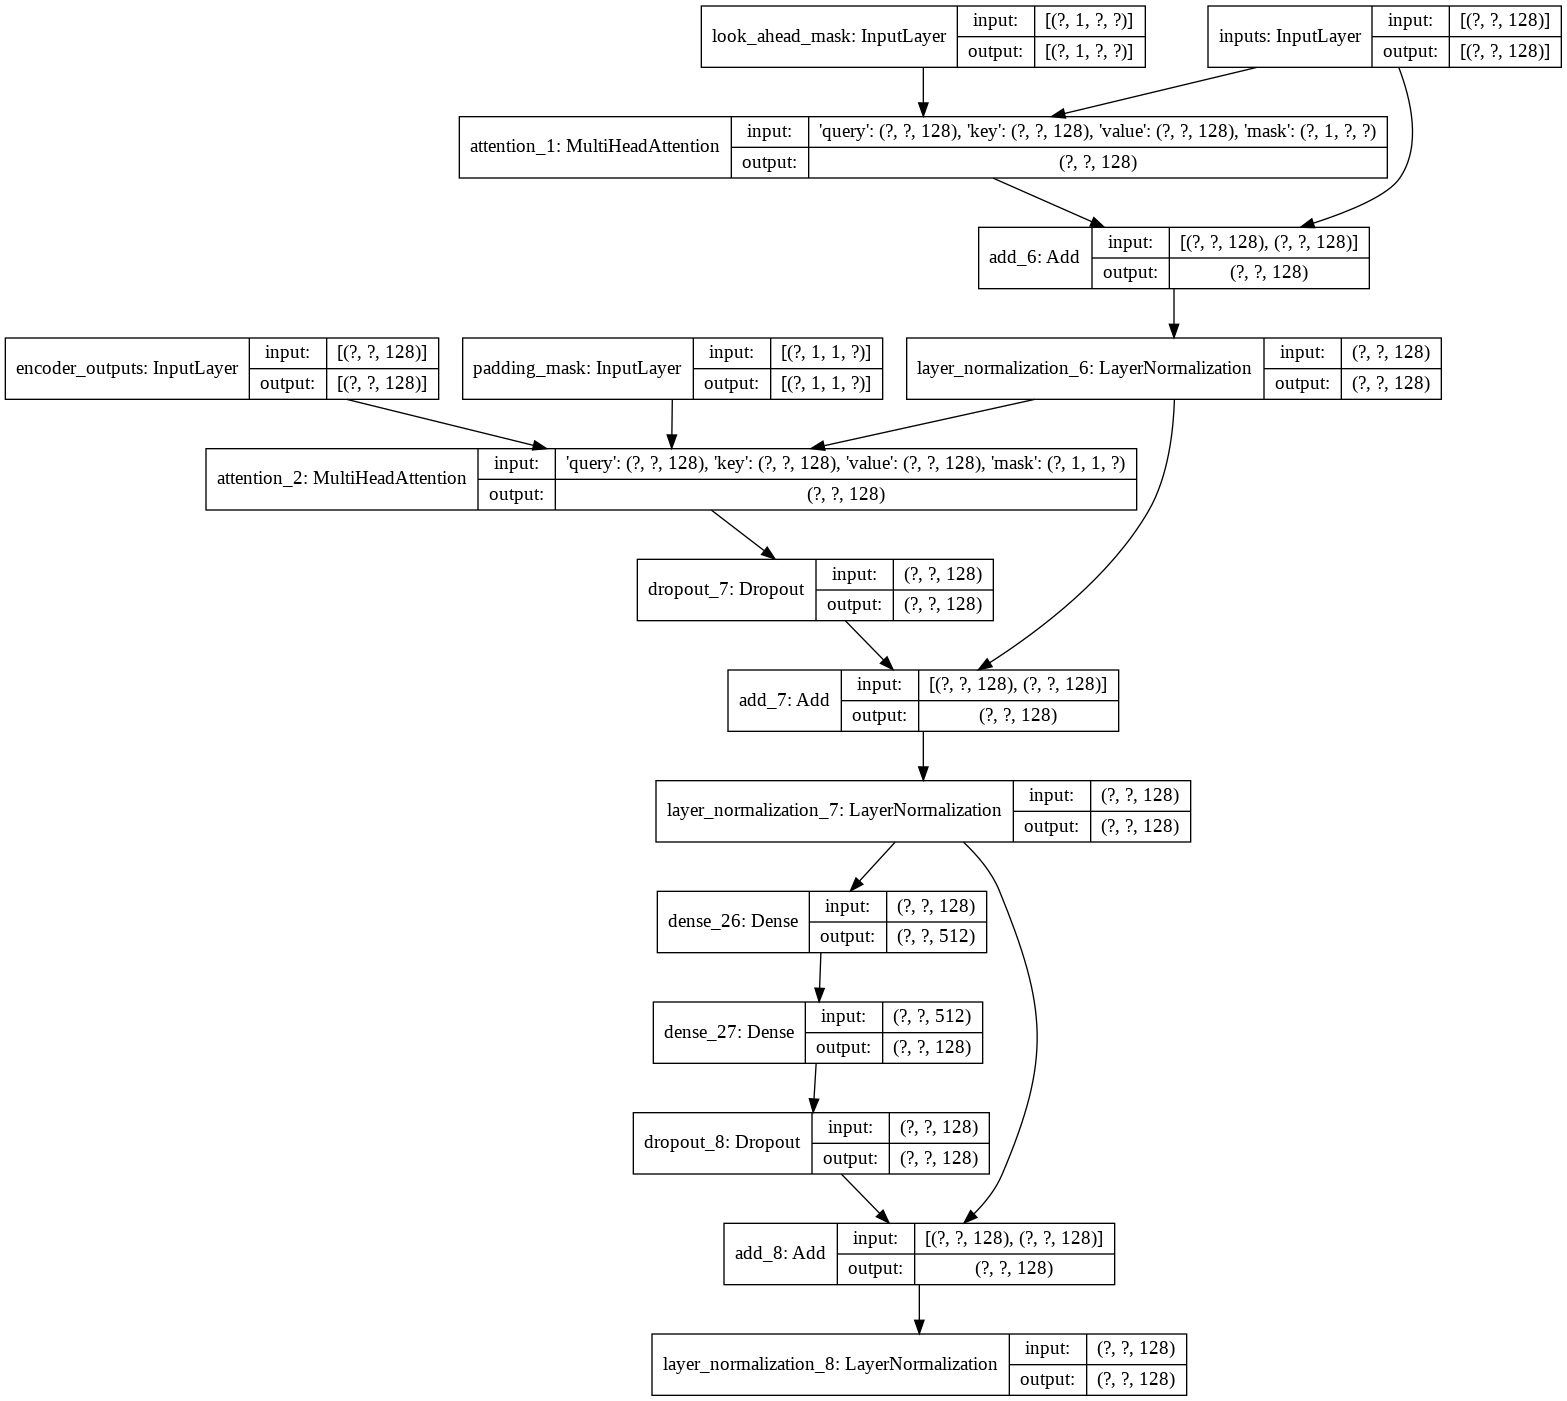

In [ ]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

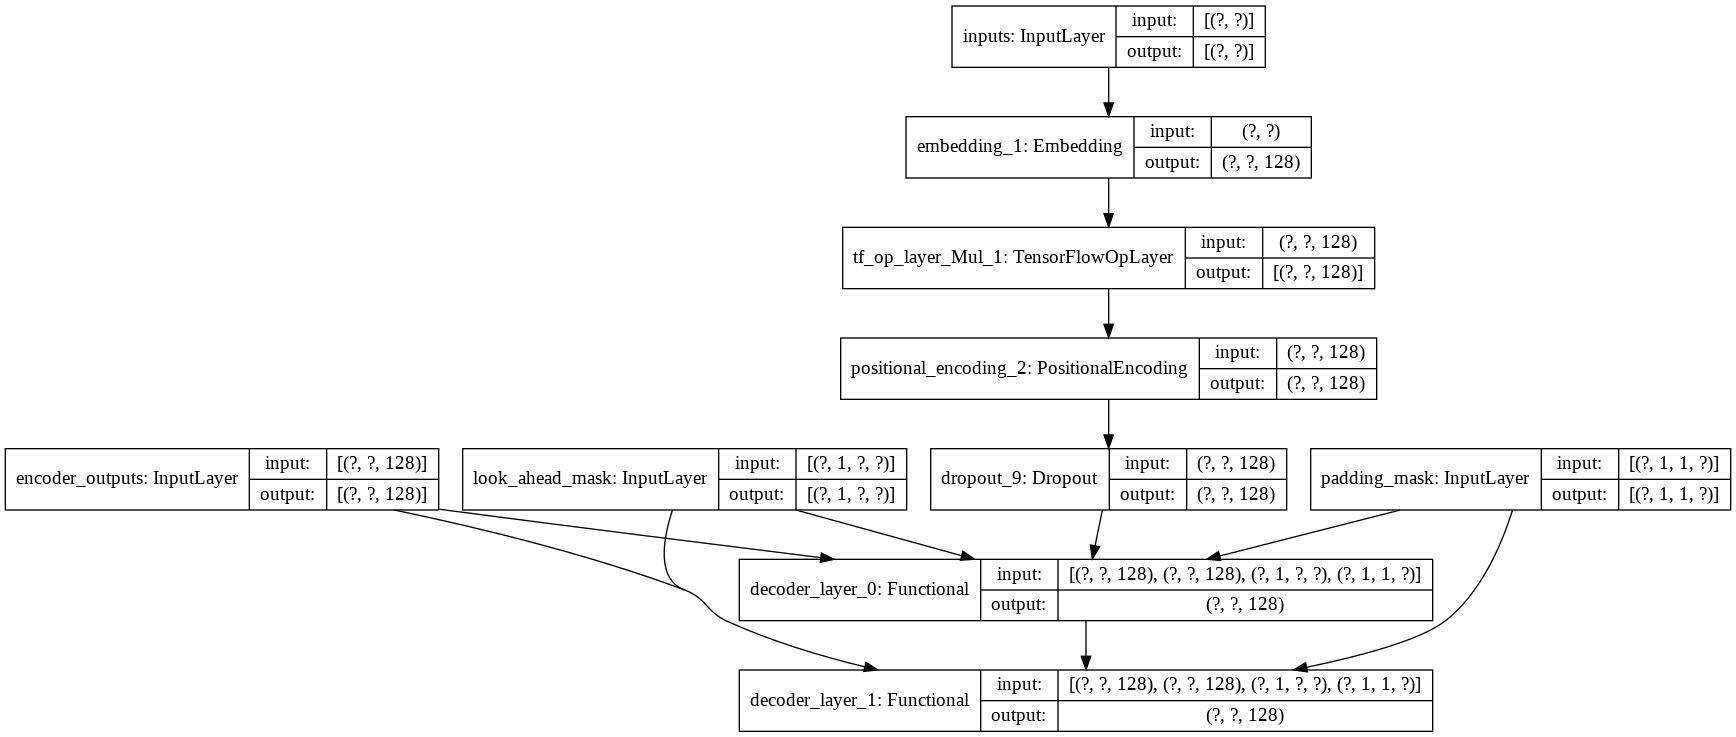

In [ ]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

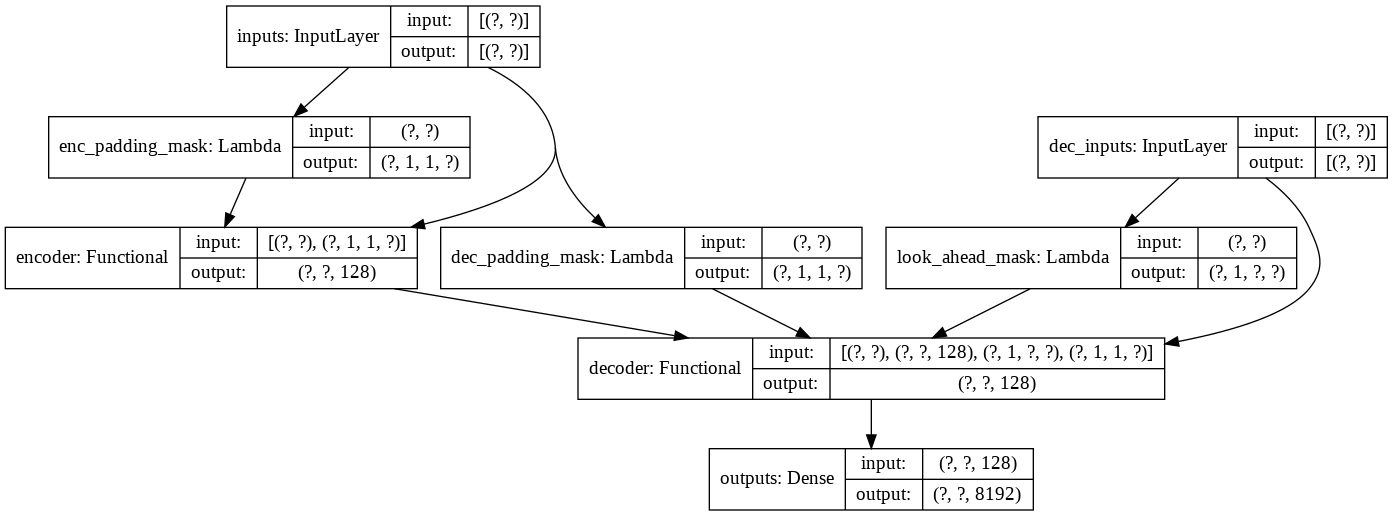

In [ ]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps
    
  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

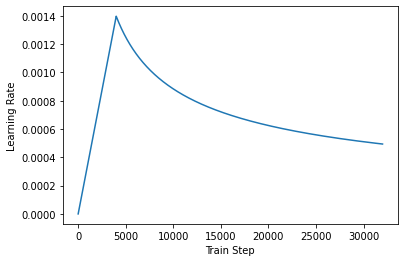

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(32000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [ ]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12201472    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [ ]:
print(learning_rate)

### Fit model

Train our transformer by simply calling `model.fit()`

In [ ]:
start_time = time()

In [ ]:
history = model.fit(train_dataset, validation_data= test_dataset, epochs=EPOCHS )

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Epoch 1/40
  2/445 [..............................] - ETA: 1:23:25 - loss: 1.7034 - accuracy: 0.0000e+00

445/445 [==============================] - ETA: 0s - loss: 1.1700 - accuracy: 0.0572

445/445 [==============================] - 86s 194ms/step - loss: 1.1700 - accuracy: 0.0572 - val_loss: 0.6865 - val_accuracy: 0.0764
Epoch 2/40
445/445 [==============================] - 36s 81ms/step - loss: 0.7817 - accuracy: 0.0732 - val_loss: 0.6022 - val_accuracy: 0.0770
Epoch 3/40
445/445 [==============================] - 35s 79ms/step - loss: 0.6924 - accuracy: 0.0779 - val_loss: 0.5510 - val_accuracy: 0.0789
Epoch 4/40
445/445 [==============================] - 36s 80ms/step - loss: 0.6210 - accuracy: 0.0827 - val_loss: 0.4969 - val_accuracy: 0.0819
Epoch 5/40
445/445 [==============================] - 35s 79ms/step - loss: 0.5582 - accuracy: 0.0883 - val_loss: 0.4485 - val_accuracy: 0.0874
Epoch 6/40
445/445 [==============================] - 35s 79ms/step - loss: 0.4990 - accuracy: 0.0942 - val_loss: 0.4154 - val_accuracy: 0.0907
Epoch 7/40
445/445 [==============================] - 36s 80ms/step - loss: 0.4417 - accuracy: 0.1009 - val_loss: 0.3645 - val_accuracy: 0.0972
Ep

In [ ]:
training_time = time() - start_time

## Generalization Curve

In [ ]:
y= 0.15
r= .02
#2DFaWc2QXjfvBqffih0ah8SFyhe_6Vt51s82egHmNKVbjfQZZ

In [ ]:
params_print = ["ACCURACY :"+ str(history.history['accuracy'][-1]),
                "VAL_ACCURACY :"+ str(history.history['val_accuracy'][-1]),
                "------ TRANSFORMER---------- :",
                "UNITS :"+ str(UNITS),
                "LAYERS :"+ str(NUM_LAYERS),
                "DROPOUT :"+ str(DROPOUT),
                "D_MODEL :"+ str(D_MODEL),
                "NUM_HEADS :"+ str(NUM_HEADS),
                "------ DATASET---------- :",
                "BATCH_SIZE :"+ str(BATCH_SIZE),
                "TRAINING_RATIO :"+ str(TRAINING_RATIO),
                "BUFFER_SIZE :"+ str(BUFFER_SIZE),
                "------ TRAINING---------- :",
                "EPOCHS:"+ str(EPOCHS),
                "TIME:"+ str(format(training_time,".3f")),
                "TIME:"+ str(training_time//60)+" m"+ str(training_time%60)+" s",
                "REPLICAS:"+ str(strategy.num_replicas_in_sync)
                ]


In [ ]:

ATTEMPT = 2
i = 0
for x in params_print:
  plt.text(43, y - r*i , x , fontsize=14 , horizontalalignment='left',verticalalignment='bottom')
  i += 1
# set other hyperparams also
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

fig1 = plt.gcf()
# fig1.savefig('graph.png', dpi=100)
plt.savefig( "graph" + '.png', bbox_inches='tight')

plt.show()
plt.draw()

#from google.colab import files
#files.download(str(ATTEMPT)+".png")

In [ ]:

ATTEMPT = 2
i = 0
for x in params_print:
  plt.text(43, y - r*i , x , fontsize=14 , horizontalalignment='left',verticalalignment='bottom')
  i += 1
# set other hyperparams also
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig1 = plt.gcf()
# fig1.savefig('graph.png', dpi=100)
plt.savefig( "graph" + '.png', bbox_inches='tight')

plt.show()
plt.draw()

#from google.colab import files
#files.download(str(ATTEMPT)+".png")

## Save Model


In [ ]:
filename = 'weights.h5'
model.save_weights(filename)

## Load Model

## Work with saved data

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [ ]:
def evaluate(sentence):
  # sentence = preprocess_sentence(sentence)
  sentence = sinhala_pre.preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  # word_index = []
  prediction = evaluate(sentence).numpy()
  # print(prediction)
  # print(type(prediction))
  # predicted_sentence = ''
  predicted_sentence = tokenizer.decode(
       [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Indexes: {}'.format(prediction))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

# Responses for Questions Related to the Trained Data (Not in the Data Set)





In [ ]:
predict('ඔයා විවාහ වෙන්නේ කවදද?')

In [ ]:
!pip install gtts
!pip install pyngrok

In [ ]:
from gtts import gTTS
from IPython.display import Audio
from IPython.display import display
from flask import Flask
from pyngrok import ngrok
from flask import render_template,request
port_no = 5000

In [ ]:
app = Flask(__name__)
ngrok.set_auth_token("2Ctc8Z7E2rsdxLdD4uSbTlGLGA9_kRpe3rH345yPgGcAX28L")
public_url =  ngrok.connect(port_no).public_url




@app.route('/', methods=['GET'])
def home():
  return render_template('index.html')

@app.route('/', methods=['GET', "POST"])
def predict1():


  input_text = request.form['Age']
  if input_text == "හෙලෝ" or input_text == "හලෝ" or input_text == "හයි" or input_text == "හායි":
    tts = gTTS(text="හායි ඔයාට කොහොමද ", lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = "හායි ඔයාට කොහොමද "
  

  elif input_text == "ඔයා කවුද" or input_text == "ඔයාගේ නම මොකක්ද" or input_text == "නම" :
    tts = gTTS(text="මගේ නම ටිකිරි ", lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = "මගේ නම ටිකිරි "

  elif input_text == "ඔයා කවුද" or input_text == "ඔයාගේ නම මොකක්ද" or input_text == "නම" :
    tts = gTTS(text="මගේ නම ටිකිරි ", lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = "මගේ නම ටිකිරි "

  elif input_text == "හෙලෝ කොහොමද" or input_text == "හායි කොහොමද" or input_text == "කොහොමද ඔයාට" :
    tts = gTTS(text="    "+"මට හොදයි ඔයාට", lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = "මට හොදයි ඔයාට"

  elif input_text == "සුබ උදෑසනක්" or input_text == "ගුඩ් මෝනින්" or input_text == "සුබ දවසක්" or input_text == "සුබ දහවලක්" or input_text == "සුබ රාත්‍රියක්" or input_text == "සුබ වේවා" or input_text == "ජය වේවා":
    tts = gTTS(text="    "+"එසේම වේවා", lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = "එසේම වේවා"

  

  elif input_text == "ආයුබෝවන්":
    tts = gTTS(text="    "+"ආයුබෝවන්", lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = "ආයුබෝවන්"

  else:
    tts = gTTS(text=predict(input_text), lang='si')
    tts.save('temp2.wav')
    sound_file = '/content/temp2.wav'
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)##
    prediction1 = predict(input_text)

  return render_template('index.html', prediction_text=prediction1)
 
  
  # if prediction==1:
  #   return render_template('index.html', prediction_text='Death event took Place. Person is no more')
  # else:
  #   return render_template('index.html', prediction_text='Death event not took Place. Person is alive')

print(f"To acces the Gloable link please click {public_url}")
app.run(port=port_no)

In [ ]:
predict('ඔයාට කොහොමද?')

In [ ]:
predict('මට ආදරෙයිද')

In [ ]:
predict('සිල් ගත්තද?')

# Responses for Questions out of the Domain

In [ ]:
predict('රුහුණ කැම්පස් එක තියෙන්නේ කොහෙද?')

In [ ]:
predict('මට සෙට් වෙන්නේ මොන වගේ ජොබ් එකක්ද?')

In [ ]:
predict('ඔයාට පිස්සුද')

In [ ]:
predict('රටේ අගමැති කවුද?')

In [ ]:
file_data = pd.read_csv('/content/Random_samples.csv', header = None)
file_data=file_data.astype(str)
rand_questions = file_data[0][0:].tolist()

for q in rand_questions[10:]:
  print('------------------------------------------')
  predict(q)

In [ ]:
file_data

In [ ]:
predict('සුබ උදෑසනක්')

### From existing dataset

In [ ]:
# for i in random.sample(range(1, 1000), 3):
#   predict(b_data[0][i])
#   print("Actual :"+ b_data[1][i])

In [ ]:
# for q in rand_questions:
#   predict(q)

### From random questions

In [ ]:
# Sample question: i really , really , really wanna go , but i cannot . not unless my sister goes .
# Sample answer: i am working on it . but she does not seem to be going for him .

## From Saved model and data

### Create new tokenizer

In [ ]:
# new_tokenizer = SinhalaTokenizer()
# new_tokenizer.create_data_using_pickle_file("data.pkl")

### Load saved model

In [ ]:
# new_model = transformer(
#       vocab_size=VOCAB_SIZE,
#       num_layers=NUM_LAYERS,
#       units=UNITS,
#       d_model=D_MODEL,
#       num_heads=NUM_HEADS,
#       dropout=DROPOUT)

# new_model.load_weights(filename)

## Evaluate using new tokenizer and the model

In [ ]:
# def evaluate_new(sentence):
#   # sentence = preprocess_sentence(sentence)
#   sentence = sinhala_pre.preprocess_sentence(sentence)

#   sentence = tf.expand_dims(
#       START_TOKEN + new_tokenizer.encode(sentence) + END_TOKEN, axis=0)

#   output = tf.expand_dims(START_TOKEN, 0)

#   for i in range(MAX_LENGTH):
#     predictions = new_model(inputs=[sentence, output], training=False)  # ! NEW MODEL IS HERE

#     # select the last word from the seq_len dimension
#     predictions = predictions[:, -1:, :]
#     predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

#     # return the result if the predicted_id is equal to the end token
#     if tf.equal(predicted_id, END_TOKEN[0]):
#       break

#     # concatenated the predicted_id to the output which is given to the decoder
#     # as its input.
#     output = tf.concat([output, predicted_id], axis=-1)

#   return tf.squeeze(output, axis=0)


# def predict_new(sentence):
#   # word_index = []
#   prediction = evaluate_new(sentence).numpy()
#   # print(prediction)
#   # print(type(prediction))
#   # predicted_sentence = ''
#   predicted_sentence = new_tokenizer.decode(
#        [i for i in prediction if i < new_tokenizer.vocab_size])

#   print('Input: {}'.format(sentence))
#   print('Indexes: {}'.format(prediction))
#   print('Output: {}'.format(predicted_sentence))

#   return predicted_sentence

In [ ]:
# output = predict_new('අම්මා ඔයාට මොකද කිව්වේ ?')

In [ ]:
# output = predict_new('ඔබේ හිසකෙස් එවැනි පෙනුමක් ලබා ගන්නේ කෙසේද?')


# Summary

Here we are, we have implemented a Transformer in TensorFlow 2.0 in around 500 lines of code.

In this tutorial, we focus on the two different approaches to implement complex models with Functional API and Model subclassing, and how to incorporate them.

Try using a different dataset or hyper-parameters to train the Transformer! Thanks for reading.


In [ ]:
df1 = pd.read_csv('/content/123.csv')

In [ ]:
import pandas as pd

In [ ]:
df = pd.concat([df1, df2], axis=1, ignore_index=False)

In [ ]:
# import libraries
import glob
import pandas as pd

# get the absolute path of all Excel files 
allExcelFiles = glob.glob("/content/*.xlsx")

# read all Excel files at once
df = pd.concat(pd.read_excel(excelFile) for excelFile in allExcelFiles,)

In [ ]:
df